# Analysis of CrowdFlower job #764099: sentence-level CID verification task for training BeFree

Tong Shu Li<br>
Created on: Friday 2015-08-14<br>
Last updated: 2015-08-14

Crowdsourcing is a good method for gathering large amounts of data which can be used to train machine learning algorithms. Our collaboration with BeFree involves generating a large amount of extra training data in the hopes that this will improve BeFree's overall performance.

A set of 2756 PubMed abstracts was sent to us by Alex and Laura containing annotated chemicals and diseases using tmChem and DNorm. For this dataset, a total of 17198 sentences contained 5160 unique chemical-disease identifier pairs which co-occurred within the same sentence. The 5160 relation pairs were judged by the crowd as to whether the sentence says that the chemical is causing the disease.

In this notebook, we look at the results from the job and pass it off to Alex and Laura to see if it will improve BeFree's performance.

### Task Background

CrowdFlower job #764099 represents a late iteration of the sentence-level CID verification task. In prior jobs (#761593, #755704), the interface and wording of the answer choices were refined. We found that the crowd was unable to determine if a highlighted concept was a chemical or disease in context. However, they were very good at determining if the two highlighted concepts were related to one another.

We also found that asking the workers to rate their own confidence in their work was not terribly useful. Very few workers chose that they were not confident in their work, likely in fear that they would not be trusted as much. Therefore user rated confidence was found to be a very poor estimator of the ambiguity of a work unit.

Finally, there were three choices for what is really a simple binary judgement task. The third choice "[chemical]-induced [other disease] causes [highlighted disease]", was originally meant to help the crowd judge that such a structure meant that the highlighted chemical was not causing the highlighted disease, as stated by the BioCreative annotation guidelines. Without such a choice, the crowd was annotating these relationships as true rather than false. However in subsequent iterations of the task it was found that only a tiny fraction of the sentences follow this structure. However, it was decided to retain the third choice as a means of making it more difficult for randomly guessing workers and computer programs to complete the job.

The task was refined with increasingly large amounts of data provided by the BioCreative committee. The original testset consisted of 30 abstracts from the training data. Most of the iterations were performed on this 30 abstracts. Immediately prior to job #764099, a test on 200 abstracts from the development data was performed. This had two main advantages: it showed that the crowd was bad at performing the NER recognition task, and it also generated a large number of sentences which could be used as test questions for this task. Since the amount of work an individual worker can perform is capped by the number of unique test questions, generating the test questions is actually a non-trivial task.

### Job #764099 details

Parameter | Value
--- | ---
Job ID | #764099
Rows per page | 6
Judgements per row | 5
Payment per page | 12 cents USD
Payment per row | 2 cents USD
Minimum CrowdFlower contributor level | 2
Minimum time per page | 18 seconds
Maximum judgements per worker | No cap (limited by test questions only)
Minimum worker accuracy threshold | 70%
Acceptable answer distribution | yes_indirect: 0-20%, yes_direct: 0-95%, no_relation: 0-95% (monitoring begins at 20 rows)
Number of test questions | 553 total, 2 were disabled
Test question origin | sent_dev_set_762850, sent_train_set_revised_760841, sent_work_dev_set_761593 (see sent_test_ques_processing.ipynb for details)
Date of launch | 12:50 pm 2015-08-14 Pacific Daylight Time
Date of completion | 8:00 pm 2015-08-14 Pacific Daylight Time
Total cost before bonuses | \$763.92 USD
Total cost after bonuses | $763.92 USD





---

In [1]:
from __future__ import division
from collections import defaultdict
from IPython.display import Image
import datetime as dt
import matplotlib as plt
import numpy as np
import os
import pandas as pd
import pycountry

In [2]:
matplotlib inline

In [3]:
from src.filter_data import filter_data
from src.aggregate_results import *

In [4]:
UNITS_PER_PAGE = 6
TRUST_THRESHOLD = 0.7

---

In [5]:
def convert_time(text):
    """
    Given the time in CrowdFlower's output format,
    convert it to a Python datetime object.
    CrowdFlower time stamps are in UTC.
    
    CrowdFlower timestamps have the following format:
    
    month/day/year hour:minute:second
    
    Example:
    
    8/2/2015 00:26:24
    """
    return dt.datetime.strptime(text, "%m/%d/%Y %H:%M:%S")

def time_elapsed(start, stop):
    """
    Given two Python datetime objects, determines the number
    of seconds between those two times.
    """
    seconds = int((stop - start).total_seconds())
    assert seconds >= 0
    return seconds

def determine_time_taken(dataframe):
    """
    Given a dataframe with the responses from one worker,
    determines the time taken for one page of work.
    """
    def time_taken_wrapper(row):
        return time_elapsed(row[0], row[1])
    
    if dataframe.empty:
        return pd.Series()
    
    time_taken = dataframe[["_started_at", "_created_at"]].apply(time_taken_wrapper, axis = 1)
    return time_taken

def time_stats(time_series):
    """
    Given the time taken for each individual work unit,
    determines some stats.
    """
    return (time_series.min(), time_series.median(), time_series.max())

def get_country_name(code):
    if isinstance(code, str):
        return pycountry.countries.get(alpha3 = code).name.split(",")[0]
    
    # code is missing (NaN)
    return "unknown"

## Worker analysis

Before we look at the worker responses, let us examine the workers themselves.

In [6]:
loc = "data/crowdflower/results/job_764099"
fname = "job_764099_worker_summary.csv"
worker_data = pd.read_csv(os.path.join(loc, fname), sep = ',')

In [7]:
# add a column that tells us if a worker was flagged
worker_data["flagged"] = worker_data["flagged_at"].map(lambda x: isinstance(x, str))

In [8]:
worker_data.shape

(520, 19)

In [9]:
worker_data.head()

,worker_id,external_id,judgments_count,missed_count,golds_count,forgiven_count,channel,country,region,city,last_ip,flagged_at,rejected_at,bonus,flag_reason,trust_overall,submission_rate,level_2_contributors,flagged
0,2253549,3174334,6,2,6,0,prodege,CAN,NaN,NaN,70.71.36.231,NaN,NaN,0,NaN,0.6667,360,1,False
1,3626598,94399,18,0,8,0,prodege,CAN,ON,Sault Sainte Marie,70.51.130.192,NaN,NaN,0,NaN,1.0000,360,1,False
2,4438583,607536,6,2,6,0,treasuretrooper,USA,GA,Hephzibah,68.217.202.244,NaN,NaN,0,NaN,0.6667,0,1,False
3,6329782,3430360,6,3,6,0,clixsense,IDN,04,Jakarta,114.79.28.109,NaN,NaN,0,NaN,0.5000,0,1,False
4,6330007,2492964,96,4,21,0,clixsense,AUS,06,Hobart,101.178.23.28,NaN,NaN,0,NaN,0.8095,360,1,False


### Quiz stats:

How many workers made zero judgments? How many workers took the test but failed? How many workers passed the quiz?

In [10]:
# total workers:
len(worker_data)

520

In [11]:
# zero judgments (gave up immediately?)
len(worker_data.query("judgments_count == 0"))

230

In [12]:
# made at least one judgement
len(worker_data.query("judgments_count > 0"))

290

In [13]:
# saw only the quiz
len(worker_data.query("judgments_count == 6"))

134

In [14]:
# saw some real work (passed initial quiz)
len(worker_data.query("judgments_count > 6"))

156

In [15]:
# saw only the quiz and passed, but did no real work
len(worker_data.query("judgments_count == 6 and trust_overall >= 0.7"))

6

In [16]:
# failed the initial quiz
len(worker_data.query("judgments_count == 6 and trust_overall < 0.7"))

128

In [17]:
# eventually failed out of the job
len(worker_data.query("judgments_count > 6 and trust_overall < 0.7"))

13

In [18]:
# had good trust score but was kicked out due to weird answer distribution
len(worker_data.query("judgments_count > 6 and trust_overall >= 0.7 and flagged"))

9

In [19]:
# had good trust score but was kicked out due to weird answer distribution
good_workers = worker_data.query("judgments_count > 6 and trust_overall >= 0.7 and ~flagged")
print len(good_workers)

134


### Summary of worker distribution

A diagram detailing how the workers were distributed is given below:

<img src="data/crowdflower/results/job_764099/job_764099_worker_distribution.png">

---

### Statistics about the good workers

In [20]:
good_workers.head()

,worker_id,external_id,judgments_count,missed_count,golds_count,forgiven_count,channel,country,region,city,last_ip,flagged_at,rejected_at,bonus,flag_reason,trust_overall,submission_rate,level_2_contributors,flagged
1,3626598,94399,18,0,8,0,prodege,CAN,ON,Sault Sainte Marie,70.51.130.192,NaN,NaN,0,NaN,1.0000,360,1,False
4,6330007,2492964,96,4,21,0,clixsense,AUS,06,Hobart,101.178.23.28,NaN,NaN,0,NaN,0.8095,360,1,False
9,6572540,3908965,138,1,28,0,clixsense,PRT,19,Setúbal,84.91.152.123,NaN,NaN,0,NaN,0.9643,99,1,False
14,9336290,4251248,414,4,74,0,clixsense,COL,NaN,NaN,181.62.183.168,NaN,NaN,0,NaN,0.9459,371,1,False
15,9832767,2758095,72,1,17,0,clixsense,IND,25,Sivaganga,117.206.125.9,NaN,NaN,0,NaN,0.9412,360,1,False


In [21]:
good_worker_ids = set(good_workers["worker_id"])

### Where did the good workers come from?

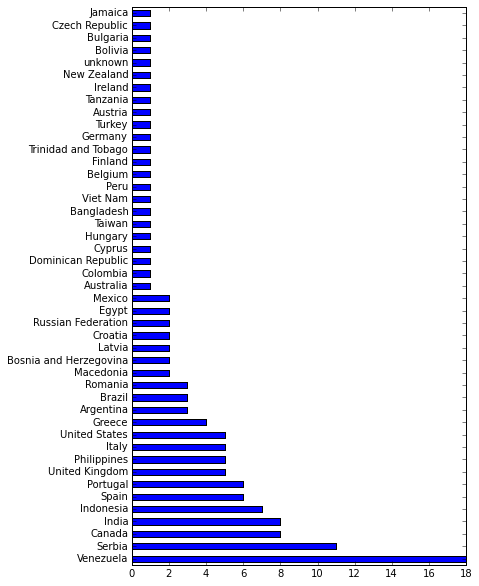

In [22]:
good_workers["country"].map(get_country_name).value_counts().plot(kind = "barh", figsize = (6, 10))

### What were their final trust scores?

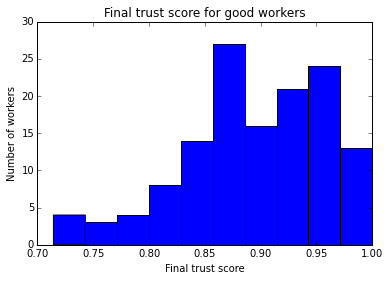

In [23]:
graph = good_workers["trust_overall"].plot(kind = "hist", title = "Final trust score for good workers")
graph.set_ylabel("Number of workers")
graph.set_xlabel("Final trust score")

### How much work did the good workers do?

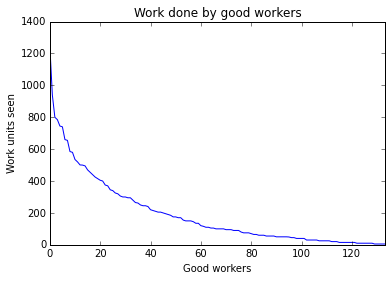

In [24]:
# plot the amount of work done by the good workers
# only count real work units, not the test questions
work_done = good_workers[["judgments_count", "golds_count"]].apply(lambda v: v["judgments_count"] - v["golds_count"], axis = 1)

graph = pd.Series(sorted(work_done, reverse = True)).plot(title = "Work done by good workers")
graph.set_ylabel("Work units seen")
graph.set_xlabel("Good workers")

The workers deemed "good" here have not yet conclusively been proven to be good workers. They may be sophisticated computer programs. However, since it is unlikely that hackers have access to hundreds of different accounts, it like quite likely that all of the "good workers" are in fact humans. We can be confident because there was a huge amount of test questions this time, which no single worker has completely seen prior to this job.

---

## Results

Now that we know a little bit about the good workers, let's look at the results.

### Read the complete set of results:

In [25]:
settings = {
    "loc": "data/crowdflower/results/job_764099",
    "fname": "job_764099_full_with_untrusted.csv",
    "data_subset": "all",
    "min_accuracy": 0.0,
    "max_accuracy": 1.0
}

# all data collected
all_raw_data = filter_data(settings)

/usr/lib64/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (4,16,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [26]:
settings = {
    "loc": "data/crowdflower/results/job_764099",
    "fname": "job_764099_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

work_raw_data = filter_data(settings)

---

In [27]:
work_raw_data.shape

(26115, 29)

In [28]:
work_raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,disease_id,disease_name,form_sentence,original_job_id,pmid,relation_pair_id,sentence_id,uniq_id,verify_relationship_gold,verify_relationship_gold_reason
7049,770955926,8/14/2015 22:18:10,False,1711777499,NaN,8/14/2015 22:17:50,False,neodev,0.8736,11014811,...,D000744,"<span class=""disease"">immunodeficiency</span>","Novel mutation in the human <span class=""disea...",NaN,1279198,1279198_D016047_D000744,1279198_0,bcv_sentence_task_befree_0,NaN,NaN
7050,770955926,8/14/2015 22:18:18,False,1711777705,NaN,8/14/2015 22:17:49,False,elite,0.8407,33465739,...,D000744,"<span class=""disease"">immunodeficiency</span>","Novel mutation in the human <span class=""disea...",NaN,1279198,1279198_D016047_D000744,1279198_0,bcv_sentence_task_befree_0,NaN,NaN
7051,770955926,8/14/2015 22:18:30,False,1711777986,NaN,8/14/2015 22:17:46,False,neodev,0.8936,30441537,...,D000744,"<span class=""disease"">immunodeficiency</span>","Novel mutation in the human <span class=""disea...",NaN,1279198,1279198_D016047_D000744,1279198_0,bcv_sentence_task_befree_0,NaN,NaN
7052,770955926,8/14/2015 22:20:11,False,1711780634,NaN,8/14/2015 22:17:51,False,neodev,0.9500,32664120,...,D000744,"<span class=""disease"">immunodeficiency</span>","Novel mutation in the human <span class=""disea...",NaN,1279198,1279198_D016047_D000744,1279198_0,bcv_sentence_task_befree_0,NaN,NaN
7053,770955926,8/14/2015 22:22:41,False,1711784648,NaN,8/14/2015 22:17:42,False,neodev,0.9167,32035862,...,D000744,"<span class=""disease"">immunodeficiency</span>","Novel mutation in the human <span class=""disea...",NaN,1279198,1279198_D016047_D000744,1279198_0,bcv_sentence_task_befree_0,NaN,NaN


In [29]:
work_raw_data["_tainted"].value_counts()

False    25800
True       315
dtype: int64

Some judgments are tainted (due to workers flunking out or being flagged due to their answer distributions). We need to remove judgments made by these workers.

### Remove tainted rows

In [30]:
work_data = work_raw_data.query("~_tainted")

In [31]:
work_data.shape

(25800, 29)

In [32]:
work_votes = defaultdict(set)
for uniq_id, group in work_data.groupby("uniq_id"):
    work_votes[len(group["_worker_id"].unique())].add(uniq_id)
    
for votes, units in work_votes.items():
    print "Judgements {0}, # of work units: {1}".format(votes, len(units))

Judgements 5, # of work units: 5160


Since we had 5160 original rows, this is the correct number of judgements 25800 = 5 * 5160.

In [33]:
work_data["verify_relationship"].value_counts()

no_relation     21293
yes_direct       4298
yes_indirect      209
dtype: int64

---

### Worker trust over time:

For any worker, we can observe how their trust score fluctuated over time.

In [34]:
def trust_over_time(dataframe):
    res = defaultdict(list)

    list_size = 0
    for worker_id, resp in dataframe.groupby("_worker_id"):
        cum_seen = 0
        cum_missed = 0
        for fin_time, page in resp.groupby("_created_at"):
            seen = page["_golden"].sum()
            missed = page["_missed"].sum()
            
            if np.isnan(missed):
                missed = 0
                
            cum_seen += seen
            cum_missed += missed
            res[worker_id].append(1 - cum_missed / cum_seen)
            
        list_size = max(list_size, len(res[worker_id]))
        
    temp = dict()
    for worker_id, values in res.items():
        temp[worker_id] = values + [np.nan] * (list_size - len(values))
        
    return pd.DataFrame(temp)

In [35]:
temp = all_raw_data.query("_worker_id in {0}".format(list(good_worker_ids)))

In [36]:
temp.loc[:, "_created_at"] = temp.loc[:, "_created_at"].map(convert_time)
temp.loc[:, "_started_at"] = temp.loc[:, "_started_at"].map(convert_time)

/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
timeres = trust_over_time(temp)

In [38]:
timeres.head()

,3626598,6330007,6572540,9336290,9832767,10538176,11000920,11014811,11064916,11081436,...,33579408,33664647,33677822,33690273,33697726,33697823,33719546,33732804,33746717,33924850
0,1,1,1,0.833333,1.000000,1,1,1.000000,0.833333,0.833333,...,1,1.000000,0.833333,1,0.833333,1,1.000000,1.000000,1,0.833333
1,1,1,1,0.857143,1.000000,1,1,1.000000,0.857143,0.857143,...,1,0.857143,0.857143,1,0.857143,1,0.857143,0.857143,1,0.857143
2,1,1,1,0.875000,1.000000,1,1,0.875000,0.875000,0.875000,...,1,NaN,0.875000,1,0.875000,1,0.875000,0.875000,1,0.875000
3,NaN,1,1,0.888889,0.888889,1,1,0.777778,0.888889,0.888889,...,1,NaN,0.888889,1,0.888889,1,NaN,0.777778,1,0.888889
4,NaN,1,1,0.900000,0.900000,1,1,0.800000,0.900000,0.800000,...,1,NaN,0.900000,1,0.900000,1,NaN,0.800000,1,0.900000


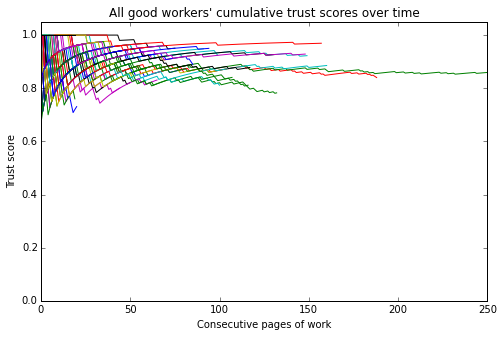

In [39]:
graph = timeres.plot(legend = False, figsize = (8, 5),
            title = "All good workers' cumulative trust scores over time")

graph.set_ylim((0, 1.05))
graph.set_xlabel("Consecutive pages of work")
graph.set_ylabel("Trust score")

### Result aggregation (no choice mapping):

Before we convert yes_indirect, let's look at the results at the original choice level.

In [40]:
raw_res = aggregate_results("uniq_id", "verify_relationship", work_data, "majority_vote",
                        ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id"])

In [41]:
raw_res.shape

(6905, 11)

In [42]:
raw_res

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_sentence_task_befree_0,no_relation,4.4746,5,1.000000,1279198,770955926,D016047,D000744,1279198_D016047_D000744,1279198_0
0,bcv_sentence_task_befree_1,no_relation,4.5624,5,1.000000,1279198,770955927,D016049,D000744,1279198_D016049_D000744,1279198_0
0,bcv_sentence_task_befree_10,no_relation,4.3854,5,1.000000,1326224,770955936,D016190,D007938,1326224_D016190_D007938,1326224_2
0,bcv_sentence_task_befree_100,no_relation,4.4380,5,1.000000,1653780,770956026,D013629,D064420,1653780_D013629_D064420,1653780_1
0,bcv_sentence_task_befree_1000,yes_direct,3.7969,4,0.803492,9808489,770956927,D020123,D064420,9808489_D020123_D064420,9808489_2
1,bcv_sentence_task_befree_1000,no_relation,0.9286,1,0.196508,9808489,770956927,D020123,D064420,9808489_D020123_D064420,9808489_2
1,bcv_sentence_task_befree_1001,no_relation,2.6985,3,0.617548,9808489,770956928,D016572,D064420,9808489_D016572_D064420,9808489_2
0,bcv_sentence_task_befree_1001,yes_direct,1.6712,2,0.382452,9808489,770956928,D016572,D064420,9808489_D016572_D064420,9808489_2
0,bcv_sentence_task_befree_1002,no_relation,4.5149,5,1.000000,9808489,770956929,D020123,D006973,9808489_D020123_D006973,9808489_7
0,bcv_sentence_task_befree_1003,no_relation,4.7797,5,1.000000,9808489,770956930,D014280,D006973,9808489_D014280_D006973,9808489_7


In [43]:
raw_res.to_csv("data/crowdflower/results/job_764099/job_764099_raw_agg_results.tsv", sep = '\t', index = False)

### Did any work units have "yes_indirect" as the top answer?

In [44]:
indirect_top = set()
for uniq_id, group in raw_res.groupby("uniq_id"):
    if group["verify_relationship"].iloc[0] == "yes_indirect":
        indirect_top.add(uniq_id)
        
print "# of questions where yes_indirect was the top choice: {0}".format(len(indirect_top))
indirect_top_data = raw_res.query("uniq_id in {0}".format(list(indirect_top)))

# of questions where yes_indirect was the top choice: 8


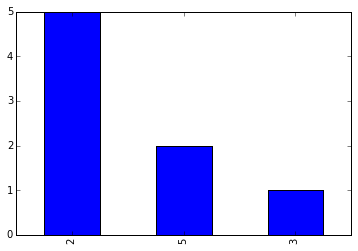

In [45]:
# when yes_indirect was the top answer, how many people voted for it?
indirect_top_data.query("verify_relationship == 'yes_indirect'")["num_votes"].value_counts().plot(kind = 'bar')

In [46]:
indirect_top_data.sort("num_votes", ascending = False)

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_sentence_task_befree_1496,yes_indirect,4.5475,5,1.000000,11474550,770957423,D006145,D006930,11474550_D006145_D006930,11474550_10
0,bcv_sentence_task_befree_4428,yes_indirect,4.5142,5,1.000000,22875460,770960358,D007980,D058866,22875460_D007980_D058866,22875460_3
0,bcv_sentence_task_befree_4853,yes_indirect,2.8014,3,0.602490,24128810,770960784,D000241,D013575,24128810_D000241_D013575,24128810_0
0,bcv_sentence_task_befree_1211,yes_indirect,1.8745,2,0.411887,10642416,770957138,D017953,D001249,10642416_D017953_D001249,10642416_2
1,bcv_sentence_task_befree_1211,yes_direct,1.7280,2,0.379697,10642416,770957138,D017953,D001249,10642416_D017953_D001249,10642416_2
1,bcv_sentence_task_befree_4457,yes_direct,1.7639,2,0.389502,22972055,770960388,D004967,D006470,22972055_D004967_D006470,22972055_3
0,bcv_sentence_task_befree_4457,yes_indirect,1.8871,2,0.416707,22972055,770960388,D004967,D006470,22972055_D004967_D006470,22972055_3
1,bcv_sentence_task_befree_4328,yes_direct,1.7864,2,0.400565,22542152,770960258,D001241,D003643,22542152_D001241_D003643,22542152_6
0,bcv_sentence_task_befree_4328,yes_indirect,1.7953,2,0.402561,22542152,770960258,D001241,D003643,22542152_D001241_D003643,22542152_6
1,bcv_sentence_task_befree_2508,yes_direct,1.6996,2,0.391081,16424409,770958436,C057823,D003643,16424409_C057823_D003643,16424409_13


Two work units had 5/5 votes for yes_indirect as the top vote (https://crowdflower.com/jobs/764099/units/770960358 and https://crowdflower.com/jobs/764099/units/770957423). Upon manual inspection, it seems that the crowd was right for both of the work units. However, there is poor agreement among the crowd when we keep the yes_indirect choice, so we will also look at what happens when we map it to "no_relation".

### Results when yes_indirect is mapped to "no_relation" or "yes_direct":

In [47]:
# take positive votes only, indirect is yes
res_pos_yes = aggregate_results("uniq_id", "verify_relationship", work_data,
                                    "positive_signal_only",
                                     ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id"],
                                    "yes_direct", {"yes_indirect" : "yes_direct"})

In [48]:
# take positive votes only, indirect is no
res_pos_no = aggregate_results("uniq_id", "verify_relationship", work_data,
                                    "positive_signal_only",
                                     ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id"],
                                    "yes_direct", {"yes_indirect" : "no_relation"})

In [49]:
res_pos_yes.shape

(10028, 11)

In [50]:
res_pos_no.shape

(10068, 11)

In [51]:
res_pos_yes.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_sentence_task_befree_0,yes_direct,0.0000,0,0,1279198,770955926,D016047,D000744,1279198_D016047_D000744,1279198_0
0,bcv_sentence_task_befree_0,no_relation,4.4746,5,1,1279198,770955926,D016047,D000744,1279198_D016047_D000744,1279198_0
0,bcv_sentence_task_befree_1,yes_direct,0.0000,0,0,1279198,770955927,D016049,D000744,1279198_D016049_D000744,1279198_0
0,bcv_sentence_task_befree_1,no_relation,4.5624,5,1,1279198,770955927,D016049,D000744,1279198_D016049_D000744,1279198_0
0,bcv_sentence_task_befree_10,yes_direct,0.0000,0,0,1326224,770955936,D016190,D007938,1326224_D016190_D007938,1326224_2


In [52]:
res_pos_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_sentence_task_befree_0,yes_direct,0.0000,0,0,1279198,770955926,D016047,D000744,1279198_D016047_D000744,1279198_0
0,bcv_sentence_task_befree_0,no_relation,4.4746,5,1,1279198,770955926,D016047,D000744,1279198_D016047_D000744,1279198_0
0,bcv_sentence_task_befree_1,yes_direct,0.0000,0,0,1279198,770955927,D016049,D000744,1279198_D016049_D000744,1279198_0
0,bcv_sentence_task_befree_1,no_relation,4.5624,5,1,1279198,770955927,D016049,D000744,1279198_D016049_D000744,1279198_0
0,bcv_sentence_task_befree_10,yes_direct,0.0000,0,0,1326224,770955936,D016190,D007938,1326224_D016190_D007938,1326224_2


### Write results to file:

In [53]:
res_pos_yes.to_csv("data/crowdflower/results/job_764099/job_764099_agg_indirect_is_yes.tsv", sep = '\t', index = False)

In [54]:
res_pos_no.to_csv("data/crowdflower/results/job_764099/job_764099_agg_indirect_is_no.tsv", sep = '\t', index = False)

### Look at the results for only the "yes_direct" choice:

In [55]:
res_pos_only_yes = res_pos_yes.query("verify_relationship == 'yes_direct'")

In [56]:
res_pos_only_no = res_pos_no.query("verify_relationship == 'yes_direct'")

In [57]:
res_pos_only_yes.shape

(5160, 11)

In [58]:
res_pos_only_no.shape

(5160, 11)

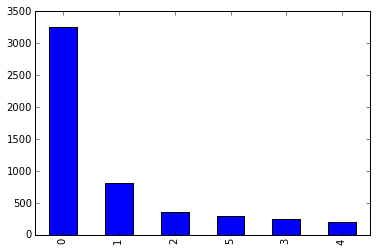

In [59]:
res_pos_only_yes["num_votes"].value_counts().plot(kind = "bar")

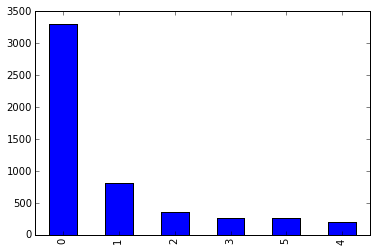

In [60]:
res_pos_only_no["num_votes"].value_counts().plot(kind = "bar")

Remember that here we are plotting the positive "yes_direct" signal only. We see that in both mappings, the vast majority of work units had 5/5 workers agreeing on the "no_relation" choice. The second next largest set of work units had 4/5 workers choosing no_relation. The relations which are true seem to be equally split among 5 and 4 votes, and there are some likely ambiguous work units where the crowd had a hard time deciding whether to say it was true or not (2 and 3 votes).